In [1]:
%matplotlib inline
# %matplotlib notebook # Does not work 
import pickle 
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import json
from hpbandster.core.result import logged_results_to_HBS_result
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import os
import sys

# yup

In [2]:
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "r", "c"]) 

In [3]:
def open_hpo_results_files(file):
    with open(file, 'rt') as f_in:
        raw = []
        for line in f_in:
            raw.append(json.loads(line))
        return raw

In [4]:
def load_hpo_results(results_dir):
    results_file = results_dir + 'results.json'
    config_file = results_dir + 'configs.json'
    return {
        'results_dir': results_dir,
        'results_lines': open_hpo_results_files(results_file),
        'config_lines': open_hpo_results_files(config_file)        
        }

In [5]:
def load_results(file):
    with open(file, 'rt') as f_in:
        results = []
        for line in f_in:
#             line = line.strip('\n')
            results.append(json.loads(line))
        data_budget = 0
#         losses = [x[3]['loss'] for x in results if x[1] == 100] # Get only runs on 100% of data
        losses = [x[3]['loss'] for x in results if x[1] >= data_budget] # Get only runs on 100% of data
        
        print(file)
        print('Length results: ', len(losses))
        
#         if 's1' in x[3]['info'].keys():
#             fold = 's1'
#         else:
#             fold = 's'

        if 's1' in results[0][3]['info'].keys():
            fold = 's1'
        else: 
            fold = 's'

        out_dict = {'loss_data': losses,
#         return {'loss_data': [x[3]['loss'] for x in results], # Get only runs on 100% of data
                'times': [x[2] for x in results if x[1] >= data_budget],
                'configs': [x[0] for x in results if x[1] >= data_budget],
                'model_file': [x[3]['info'][fold]['info']['model_file'] for x in results if x[1] >= data_budget],
                'file': file
               }
        
        if 'test_results' in results[0][3]['info'][fold]['info'].keys():
            out_dict['test_results']: [x[3]['info'][fold]['info']['test_results'] for x in results if x[1] >= data_budget]
            
    return out_dict

In [6]:
def get_best_config(*results_dirs):
    
    for results_dir in results_dirs:
        results = logged_results_to_HBS_result(results_dir)
        print( {'dir': results_dir,
                'config': results.get_id2config_mapping()[results.get_incumbent_id()]['config'],
                'mean_metric': results.get_runs_by_id(results.get_incumbent_id())[-1].info['mean_metric']
               }, '\n' )

In [7]:
now = datetime.now()
timestamp = datetime.timestamp(now)

In [8]:
def get_hpo_results_dir(workdir, hpo_method):
    
    results_dirs = []
    for root, dirs, files in os.walk(workdir, topdown=False):
        for name in dirs:
            if (hpo_method in name):
                results_dirs.append(os.path.join(root, name))
    return results_dirs

In [9]:
def get_min_loss(values):
    min_values = [min(values[0:i+1]) for i,x in enumerate(values)]
    return min_values

In [10]:
def get_avg_results(results_files, n_lim):
    res = []
    
    for r in results_files:
        r_load = load_results(r)
#         if len(r_load['loss_data']) > 100: # Load results only if they are above 100 function evaluations. Need to concat wit the other one             
        if len(r_load['loss_data']) > 100: # Load results only if they are above 100 function evaluations. Need to concat wit the other one             
            res.append(r_load)                  
        else: 
            print('Do not plot. Too small sample: ', len(r_load['loss_data']))
            
        ## Borrar
#         print(r_load['loss_data'][0:10])

    min_len = min(len(r['loss_data']) for r in res)
    max_len = max(len(r['loss_data']) for r in res)
    
    if (n_lim >0) or (n_lim<min_len):
        n_up=n_lim
    else:
        n_up = min_len

    
    ## Some stats 
    print('Min sample: ', min_len)
    print('Max sample: ', max_len)
    print('Fixed size: ', n_lim)

    losess = [r['loss_data'][0:n_up] for r in res]
    
    indexes_min = [y.index(min(y)) for y in losess] 
    print('indexes_min: ', len(indexes_min), len(res))
    
    file_stats_max = [['./' + a['file'].split('/')[-2] + '/',  a['model_file'][b], 'Metric: ', round(1 - a['loss_data'][b],4)] 
                      for a,b in zip(res, indexes_min)]
    
    max_metric_config = max(file_stats_max, key=lambda x: x[3])
    
    print('Max metric: \n', max_metric_config)
    
    
    
    min_losess = [get_min_loss(r['loss_data'][0:n_up]) for r in res]
    
#     min_losess_mean = [np.mean(list(i)) for i in zip(*losess)]
    min_losess_mean = [np.mean(list(i)) for i in zip(*min_losess)]
    
    mean_loss = [np.mean(list(i)) for i in zip(*losess)]
    
    std = [np.std(list(i)) for i in zip(*losess)]
    
    min_losess_std =  [np.std(list(i)) for i in zip(*min_losess)]
    
#     duration = plot_data['times'][n_up-1]['finished'] - plot_data['times'][0]['submitted']
    durs = [[b['finished'] - b['submitted'] for b in a['times'][0:n_up]] for a in res]

    duration_mean = [np.mean(list(i)) for i in zip(*durs)]
    
#     print('LALA: ', len(duration_mean))
    
#     print(min_losess_mean[0:10])
#     return {'loss_data': mean_loss, # According to the least number of observations
    return {'loss_data': min_losess_mean, # According to the least number of observations
            'std': std,
            'min_std': min_losess_std,
            'max_metric': max_metric_config,
            'avg_hpo': max_metric_config[0].split('_')[2].strip('/'),
#         return {'loss_data': [x[3]['loss'] for x in results], # Get only runs on 100% of data
            
            'times': res[0]['times'][0:n_up], # Time reference of the first run, not the ebst way!
            'duration_mean': duration_mean # Time reference of the first run, not the ebst way!
           }

In [11]:
def plot_results(dataset, *plots, dev_def=0, test_def=0, n=0, n_lim=0, min_dur=0, time_flag=True):
    f = plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.clf()

    plt.title(dataset.upper() + ' HPO validation set' )
    
    plt.axhline(y=dev_def, color='r', linestyle='-', label = 'Val default hp')
#     plt.axhline(y=test_def, color='g', linestyle='--', label = 'Test default hp')
    
    
    for plot_data in plots:
    
        len_data = len(plot_data['loss_data'])
        
        for i,x in enumerate(plot_data['duration_mean']):
             if sum(plot_data['duration_mean'][0:i+1]) >= min_dur:
                    break
        if time_flag:
            n_up = i+1
            print('**new n_up: ', n_up)
        else:
            if (n_lim < len_data) and (n_lim > 0):
                n_up = n_lim
            else:
                n_up = len_data        
        
#         y_results = [1 - min(plot_data['loss_data'][0:i+1]) for i,x in enumerate(plot_data['loss_data'])]
#         min_losses = get_min_loss(plot_data['loss_data'])
    
    
        metric_max_avg = [1 - x for x in plot_data['loss_data']]
#         metric_max = [1 - x for x in min_losses]

#         duration = plot_data['times'][n_up-1]['finished'] - plot_data['times'][0]['submitted']        
            
        duration = sum(plot_data['duration_mean'][0:n_up-1])
        print('Avg ' + plot_data['avg_hpo'].upper() + ' duration after ' + str(n_up) + ' func evals : ', round(duration/60,2), 'mins')
    
        if time_flag:
            x_axis = 'time'
            initial = plot_data['times'][0]['submitted']

#             idx = list(np.linspace(0, time_diff, num=len(metric_max_avg)))
            idx = [sum(plot_data['duration_mean'][0:i+1]) for i,x in enumerate(plot_data['duration_mean'])]
        
            idx = [x/60 for x in idx]
            plt.xlabel('wallclock-time [min]', fontsize = 13)
        else:
            x_axis = 'func_eval'
            idx = list(range(0,len(metric_max_avg)))
            plt.xlabel('# function evaluations', fontsize = 13)
#             plt.xlabel('# function evaluations on 100% budget', fontsize = 13)
        
        if dataset == 'tvqa':            
            plt.ylabel('Max acc per function evaluation', fontsize = 13)
        else:
            plt.ylabel('Max MAP per function evaluation', fontsize = 13)
        
        
        metric_max_avg_sliced = metric_max_avg[n:n_up]
        error = np.asarray(plot_data['min_std'])
        error_sliced = error[n:n_up]
#         metric_raw_sliced = metric_raw[n:n_up]
        
        x_idx = idx[n:n_up]
        
        p = plt.plot(x_idx, metric_max_avg_sliced, label = plot_data['avg_hpo'].upper())
        
        
        y = np.asarray(metric_max_avg_sliced)        
        
#         print(len(x_idx), len(y), len(error))
        plt.fill_between(x_idx, y-error_sliced, y+error_sliced, alpha=0.3)
        
#         print(p[0].get_color())
        
#         if raw_flag: # There is no raw data with average, because I'm plotting the average of the max
#             plt.plot(x_idx, metric_raw_sliced, label = 'Raw '+ hpo_method.upper(), color=p[0].get_color(), alpha=0.3)
# #             plt.plot(x_idx, metric_raw_sliced, label = 'Raw '+ hpo_method.upper(), alpha=0.3)
#             raw_y = np.asarray(metric_raw_sliced)
#             raw_error = np.asarray(plot_data['std'])
# #             plt.fill_between(x_idx, raw_y-raw_error, raw_y+raw_error, alpha=0.3)
        
#     plt.plot([x/hour for x in incumbent_bohb['times_finished']], incumbent_bohb['losses'])
    plt.legend()
    plt.show()
    pdf_file = 'hpo_' + dataset + '_' + x_axis + '_avg_curves.pdf'
    f.savefig(pdf_file, bbox_inches='tight')
#     pp.close()
    return [metric_max_avg, idx]



###############################
####### New Graph #############

./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_bohb/results.json
Length results:  2151
./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_bohb_1573758626/results.json
Length results:  1739
./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_bohb_1573820947/results.json
Length results:  1741
./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_bohb_1573848102/results.json
Length results:  1925
./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_bohb_1574032883/results.json
Length results:  443
Min sample:  443
Max sample:  2151
Fixed size:  100
indexes_min:  5 5
Max metric: 
 ['./hpo_results_bohb_1574032883/', './bioasq_dir/bioasq_lmart_id65_budget100_leaves15_lr0.07_n1400', 'Metric: ', 0.4518]


###############################
####### New Graph #############

./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_rs_1573636254/results.json
L

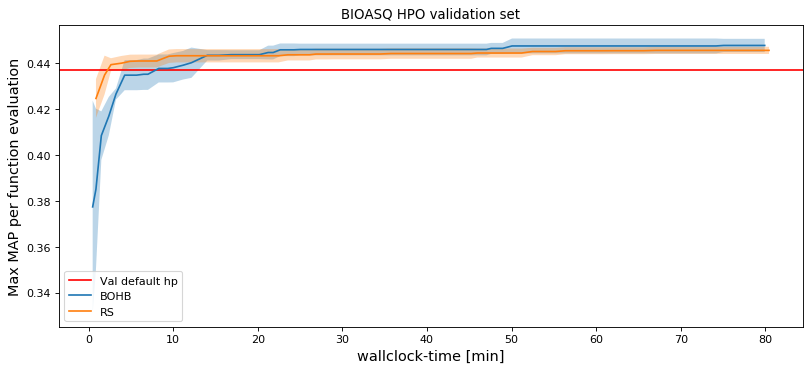



###############################
####### New Graph #############

./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_bohb_1573765824/results.json
Length results:  375
./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_bohb_1574172181/results.json
Length results:  106
./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_bohb/results.json
Length results:  598
./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_bohb_1573636384/results.json
Length results:  263
./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_bohb_1574004561/results.json
Length results:  219
Min sample:  106
Max sample:  598
Fixed size:  100
indexes_min:  5 5
Max metric: 
 ['./hpo_results_bohb_1573636384/', './robust_dir/s1/robust_s1_lmart_id136_budget100_leaves25_lr0.03_n450', 'Metric: ', 0.2465]


###############################
####### New Graph #############

./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_rs_1573636396/results.json


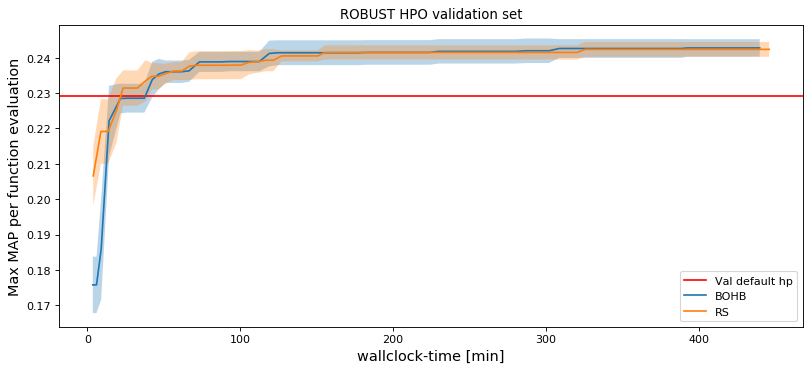



###############################
####### New Graph #############

./TVQA/workdir/hpo_results_bohb_1573570289/results.json
Length results:  1434
./TVQA/workdir/hpo_results_bohb_1574003537/results.json
Length results:  413
./TVQA/workdir/hpo_results_bohb_1573954316/results.json
Length results:  369
./TVQA/workdir/hpo_results_bohb_1574107820/results.json
Length results:  591
./TVQA/workdir/hpo_results_bohb_1574109885/results.json
Length results:  538
Min sample:  369
Max sample:  1434
Fixed size:  100
indexes_min:  5 5
Max metric: 
 ['./hpo_results_bohb_1573570289/', './workdir/tvqa_lmart_id95_budget100_leaves5_lr0.44_n1350', 'Metric: ', 0.5591]


###############################
####### New Graph #############

./TVQA/workdir/hpo_results_rs_1573570296/results.json
Length results:  281
./TVQA/workdir/hpo_results_rs_1574003525/results.json
Length results:  129
./TVQA/workdir/hpo_results_rs_1573954349/results.json
Length results:  198
./TVQA/workdir/hpo_results_rs_1574034451/results.json
Le

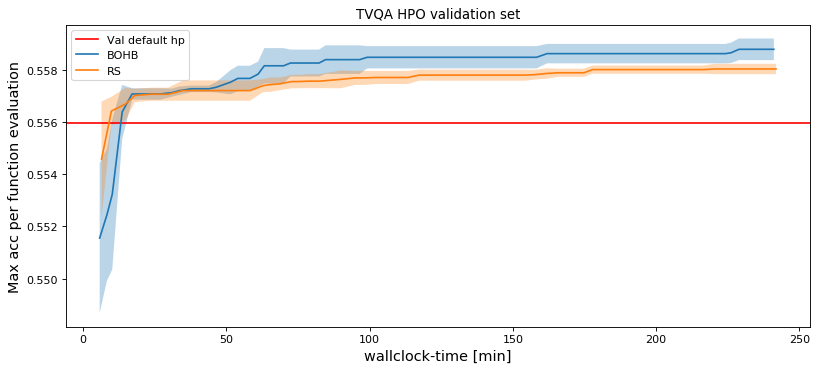

In [13]:
# For each dataset and hpo method

workdirs = [ 
            './deep-relevance-ranking/models/baselines/bioasq_dir/',
            './deep-relevance-ranking/models/baselines/robust_dir/',
            './TVQA/workdir/'
           ]
dev_defaults = [
                0.4371,
                0.2292,
                0.55597
               ]

test_defaults = [
                0.4703,
                0.2189,
                0.56291
               ]

hpo_methods = [
                'bohb', 
                'rs'
]

# adjust_min=True
# adjust= 'min' # min|max|fixed
# adjust= 'max' # min|max|fixed
adjust= 'fixed' # min|max|fixed
n_limit = 0
n_limit2 = 100

for wdir, dev_def, test_def in zip(workdirs, dev_defaults, test_defaults):
    
    dur= []
    avg_res_hpo = []
    for hpo_m in hpo_methods:
        print('\n\n###############################\n####### New Graph #############\n')
        # Get results_dir
        results_dirs = get_hpo_results_dir(wdir, hpo_m)

#         print(results_dirs)
        # Get mean, std
        results_files = [x + '/results.json' for x in results_dirs]

        if 'bioasq' in wdir.lower():
            dataset = 'bioasq'
        elif 'robust' in wdir.lower():
            dataset = 'robust'
        elif 'TVQA'.lower() in wdir.lower():
            dataset = 'tvqa'
        
#         print(dataset)
        avg_res = get_avg_results(results_files, n_limit2)
#         n_limit_hpo = len(avg_res['loss_data'])
        dur.append(sum(avg_res['duration_mean']))
        avg_res_hpo.append(avg_res)

    if adjust == 'min':
        n_limit = min(len(r['loss_data']) for r in avg_res_hpo)
    elif adjust == 'max':
        n_limit = max(len(r['loss_data']) for r in avg_res_hpo)
    elif adjust == 'fixed':
        n_limit = n_limit2
    print('set n_lim: ', n_limit)    
        
    [max_m, idx] = plot_results(dataset, *avg_res_hpo, dev_def=dev_def, test_def=test_def, n=0, n_lim=n_limit, min_dur=min(dur), time_flag=True)

        # Plot

        # Save results all results